# Purpose of this notebook
Joblib purpose is to execute a sequence of tasks in parallel by creating
workers that are consuming a generator containing the given tasks, executing
those tasks and returning the results to the master process. 
Typically, joblib is used like this:
```python
from joblib import Parallel, delayed
Parallel(n_jobs=4)(delayed(say_hello)(friend) for friend in all_my_friends)
```
A classic way to increase the performance
of parallel task execution is to not send the tasks one by one, but instead by batches. 
Doing so is called batching. This notebook aims at auditing joblib's batching logic,
and proposing improvements. 


# Introduction to batching
### Considerations in a simple setting

Say we need to execute $n$ times some task that takes $T_r$ seconds to run. The
total running time in the serial case is $n\times T_r$ seconds.


Using joblib, with `n_jobs=m`, the total running time is divided by $m$, becomming  $\frac{nT_r}{m}$.

With joblib, we must add a new term in the running time of
a task though: the time it takes for the parent process to send communicate the tasks and its
arguments to the worker. The total running time of a task becomes $T_r + T_s$, where $T_s$ accounts for accounting for data communication). 

As data communication is done, sequentially. the new theoretical running time in the parallel setting is
$\frac{n}{m}T_r + nT_s$
and the corresponding speedup is $$\frac{1}{\frac{1}{m} + \frac{T_s}{T_r}}$$

#### Modelization of the serialization time

In joblib, $T_s$ can be seen as the running time of `dispatch_one_batch`
It contains:


* a $O(1)$ part. This part includes for example calling `delayed`
  on the function to be executed
* a $O(s)$ part, where $s$ is the size of the data to serialize.

$$T_s = T_1 + T_2$$

#### The purpose of batching tasks


Until now, we assumed that the tasks were sent to the workers one by one. It implies a serialization cost of $nT_s = n(T_1 + T_2)$. We could decide to send the tasks in $b$ batches of size $\frac{n}{b}$. In this situation, The total serialization cost becomes $bT_1 + nT_2$, and the speedup is then

$$\frac{1}{\frac{1}{m} +  \frac{T_2}{T_r} + \frac{bT_1}{nT_r}}$$

#### Numerical analysis of the serialization time
The following table shows the relative weight of the two serialization terms for different values of $n$ and $b$. 
$T_1$ and $T_2$ are properly estimated in the appendix.


tasks  | batches | $bT_1$ | $nT_2$ | Total
-------|---------|--------|--------|------
1000   | 10      | 0.006  | 0.001  | 0.007
1000   | 100     | 0.059  | 0.001  | 0.060
100000 | 10      | 0.006  | 0.146  | 0.152
100000 | 10000   | 5.886  | 0.146  | 6.032

### Setting the batch size: theory vs. practice

In our simple case above, the solution to batching is easy: for $m$ workers, choose the largest possible batch size ($\frac{n}{m}$).

In practice however, the situation is more difficult. In particular,
* $n$ is unknonwn, as the tasks are given in an iterator which we dont want to consume all at once to limit memory footprint. So we do not know the ideal batch size for our problem.
* Also tasks do not take all the same time to complete. So even if we had $n$, dispatching $m$ batches of $\frac{n}{m}$ tasks would not necessarily be the best batching strategy.

We will devle deeper into joblib batching logic afterwards, but in summary, joblib takes these two points into account by dynamically updating the size of the batches it sends to the workers so that they all take (hopefully) the same time to run. The tighter the runnnig time distribution of batches, the better.


# Assessing current batching in joblib


### The benchmarks
Let's now analyze how joblib batching performs in practice. For this, we need to plug into joblib a bunch of wires to record the evolution of batches over time: their size, their running time... And also some internal state of the `Parallel` object, that is used to update the batch size.


We also need to setup a benchmark suite to test different tasks distributions.
For now, I created 4 different benchmarks:

* stationary, non-autocorrelated tasks, with low average compute-time and low variance
* stationary, non-autocorrelated tasks, with low average compute-time and low variance
* tasks following a periodic pattern, with a maximum amplitude of 0.2 seconds.
* tasks splitted in  2 kinds: the first ones are very quick to compute,
  and the next one very slow. This case emulates a setting where joblib
  was previously used on a to compute the first tasks - joblib then
  cached those tasks, and the current compute time of the first tasks
  does not represent the true compute time, but simply the cache-lookup
  time.
  
The code of these benchmarks can be found here: [joblib_benchmarks](https://github.com/pierreglaser/joblib_benchmarks)
You will need a clone of my local joblib respository, as the benchmarks run on joblib branches with batch-size introspection capabilities.

### Examinating the results
I ran my benchmark suite on joblib master and improvement branches - here are the results. 
To run the next cells, you will need [asv_to_pandas](https://github.com/pierreglaser/asv_to_pandas.git)
which is a small module i wrote to programatically access benchmarks results generated by `asv`

In [25]:
# for each benchmark, the result is a tuple containing the total running time, 
# as well as an array of records containing information about each batch.
BENCHMARK_INFO_COLS = [
    "batch_idx",                  # unique identifier. batch_idx = n means this batch was sent in nth position
    "batch_size",                 # size of the batch 
    "total_duration",             # total time between batch creation and 
    "worker_duration",            # time it took to run the task for each task in the batch (does not count serialization)
    "smoothed_duration",          # computed smoothed duration after this batch was ran.
    "previous_smoothed_duration", # smoothed duration before this batch was ran
    "used_to_compute_bs",         # was this batch used to update the smoothed duration?
    "last_influential_batch_idx", # what was the last batch used to update the smoothed duration?
    "compute_duration",           # total theroretical time needed to run the tasks. ~ worker duration.
]

In [26]:
import pandas as pd
from asv_to_pandas import create_benchmark_dataframe

Lets focus on the running time for now: by selecting the first item of each result tuple:

In [27]:
from benchmarks.bench_auto_batching import get_ideal_parallel_running_times

def get_running_time_results(bench_class):
    # results is a dictionary containing, for each benchmark class, the benchmark results
    # in the form of as pandas Series.
    results = create_benchmark_dataframe(group_by="class", use_branch_names=True)[bench_class]
    
    # each item in the series is a tuple, the 2nd item is the time it took to run the benchmark
    time_df = pd.Series([row[1] for _, row in results.iteritems()], results.index)

    # remove unnecessary index fields
    time_df.reset_index(['type', 'file', 'version', 'date', 'size', 'eta'],
                        drop=True, inplace=True)
    
    # We add a theoretical baseline which is the best benchmark results for a parallel
    # system with `n_jobs` workers: for each benchmark, the result is the benchmark time
    # in the serial case divided by the number of workers.
    tasks = get_ideal_parallel_running_times(bench_class)
    tasks.reset_index(['size', 'eta'], inplace=True, drop=True)  # we do not need these params for now
    time_df = pd.concat([tasks, time_df], axis=0)
    time_df = time_df.sort_index()
    
    return time_df

Here is how the processed time results look like:

In [28]:
time_df = get_running_time_results("AutoBatchingSuite")
time_df.head()

name                commit_hash                          n_jobs
track_cyclic_trend  default-slow-increase-fast-decrease  2         56.163179
                                                         4         28.253950
                                                         8         15.769616
                                                         16         8.126519
                    ideal_parallel_case                  2         54.760156
dtype: float64

Now, we can assess the performance of joblib compared to the ideal parallel case.

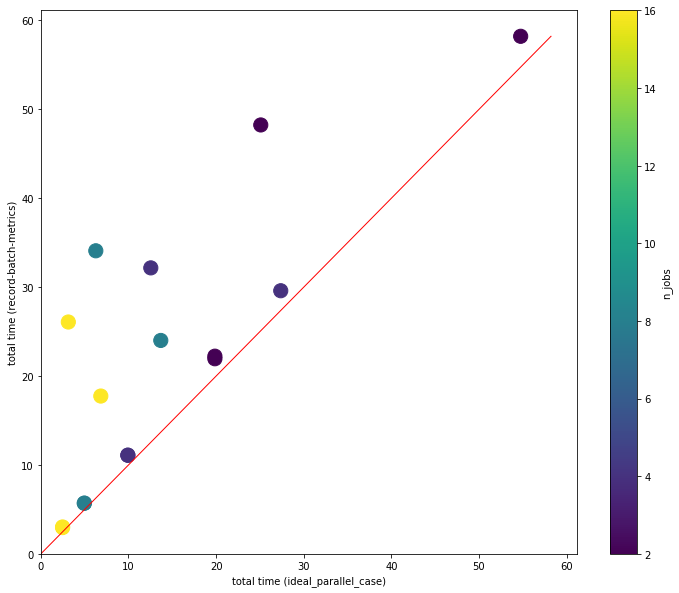

In [29]:
import matplotlib.pyplot as plt

def compare_total_running_time(bench_class, bench_name, benchmarked_branch, base_branch):
    time_df = get_running_time_results(bench_class)
    base_branch_res = time_df.loc[slice(bench_name, bench_name)].xs(base_branch, level="commit_hash")
    benchmarked_branch_res = time_df.loc[slice(bench_name, bench_name)].xs(benchmarked_branch, level="commit_hash")

    f, ax = plt.subplots(figsize=(12, 10))
    c = base_branch_res.index.get_level_values("n_jobs")
    s = 200
    pts = ax.scatter(base_branch_res, benchmarked_branch_res, s=s, c=c, marker="o")

    # draw a y = x line. Any point above this line is a regression, any point below this line
    # is an improvement
    ax.plot([0, time_df.max().max()], [0, time_df.max().max()], linewidth=1, c="red")

    ax.set_xlabel("total time ({})".format(base_branch[:30]))
    ax.set_ylabel("total time ({})".format(benchmarked_branch[:30]))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    cbar = f.colorbar(pts)
    cbar.set_label("n_jobs")

compare_total_running_time(
    "AutoBatchingSuite",
    None,  # None plots all the benchmarks, but you can also enter a specific benchmark name
    benchmarked_branch="record-batch-metrics",  # master + instrospection utilities
    base_branch="ideal_parallel_case"
)

This plot summarizes the speedups our benchmarks. Each point (x, y) represents a benchmark run for 2 different branches:
* x it total running time using some defined base branch (here, the ideal parallel setting)
* y is total running time using a benchmarked brsanch (here, joblib master)

Any point above the y=x line is an performance regression compared to the base branch, any point below the y=x line is a performance improvement.

Of course here, all points are regression, as you cannot get any better than the parallel case. But some points get actually far away from the red line, meaning that for those benchmarks, the results are particularly bad.

Right now, we only looked at total running time. We can delve deeper into how joblib changed its batching strategy over time, by using the other part of the benchmark results:

In [30]:
def get_batch_information(bench_class, **filters):
    """Select and format records containing batch information for a specific benchmark"""
    # Each line of the benchmarks dataframe contains an array of records
    results = create_benchmark_dataframe(group_by="class", use_branch_names=True)[bench_class]
    
    # filter is a dictionary that maps to a single benchmark. It must contain the branch name,
    # the benchmark name, and if any, additional benchmark parameters.
    field_names, field_values = zip(*(filters.items()))
    batch_info = results.xs(field_values, level=field_names)
    assert len(batch_info) == 1, "there should be one benchmark only at this point"
    batch_info = pd.DataFrame(batch_info.iloc[0][0], columns=BENCHMARK_INFO_COLS)
    batch_info.set_index(batch_info.batch_idx, inplace=True)
    
    # For future purposes, we re-index this dataframe from batches to tasks.
    batch_info["task_idx"] = batch_info.batch_size.cumsum()
    batch_info.set_index("task_idx", inplace=True)
    # the task_idx should be the number of tasks computed UP to this batch
    # and not including this batch, so we shift the index by one.
    batch_info = batch_info.shift(-1) 
    
    # finally, duplicate the lines to have one line per task, and not one line per batch. All tasks
    # of the same batch have the same batch info
    batch_info = batch_info.reindex(range(max(batch_info.index))).ffill().dropna()
    return batch_info

In [31]:
batch_info = get_batch_information(
    bench_class="AutoBatchingSuite", 
    n_jobs=2, 
    name="track_high_variance_no_trend",
    # commit_hash = "no-starving-backend-agnostic-split-last-batch-end-to-end-duration",
    commit_hash="record-batch-metrics")
batch_info.head()

,batch_idx,batch_size,total_duration,worker_duration,smoothed_duration,previous_smoothed_duration,used_to_compute_bs,last_influential_batch_idx,compute_duration
task_idx,,,,,,,,,
1,2.0,1.0,0.009886,0.001677,0.009886,0.000000,True,0.0,0.001382
2,3.0,1.0,0.019058,0.006641,0.000000,0.000000,False,2.0,0.006478
3,4.0,1.0,0.030772,0.015431,0.000000,0.000000,False,2.0,0.015231
4,5.0,40.0,0.350435,0.307376,0.350435,0.009886,True,2.0,0.296918
5,5.0,40.0,0.350435,0.307376,0.350435,0.009886,True,2.0,0.296918


Let's plot the evolution of batch duration, batch size and other metrics into one plot for a specific benchmark.
We also plot the profile of the tasks below.

In [32]:
from benchmarks.bench_auto_batching import get_task_profile

def plot_batch_information(bench_class, bench_name, **filters):
    batch_info = get_batch_information(bench_class, name=bench_name, **filters)
    tasks_times = get_task_profile(bench_class, bench_name, **filters)
    f, (ax , ax_taskstimes) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True, figsize=(10, 12))

    ax_taskstimes.plot(range(len(tasks_times)), tasks_times, label="task times")
    ax_taskstimes.set_xlabel("task number")
    ax_taskstimes.set_ylabel("task time")

    cm = plt.get_cmap("tab10")
    colors = iter(cm.colors)

    ax.plot(batch_info.index, batch_info.total_duration, color=next(colors), label="total_duration")
    ax.plot(batch_info.index, batch_info.compute_duration, color=next(colors), label="compute_duration")
    ax.plot(batch_info.index, batch_info.previous_smoothed_duration, color=next(colors), label="previous_smoothed_duration")

    twinax = ax.twinx()
    twinax.plot(batch_info.index, batch_info.batch_size, color=next(colors), label="batch_size")

    handles, labels = ax.get_legend_handles_labels()
    tw_handles, tw_labels = twinax.get_legend_handles_labels()
    ax.legend(handles + tw_handles, labels + tw_labels, loc="upper center",
              ncol=4, bbox_to_anchor=(0, 1, 1, 0.07))

    ax.set_ylabel("task time")
    twinax.set_ylabel("batch size")

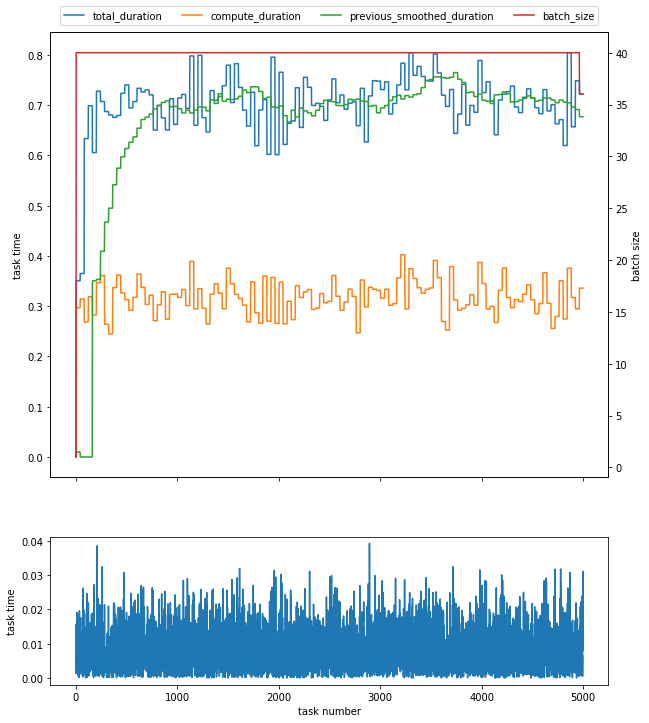

In [33]:
plot_batch_information(
    "AutoBatchingSuite",
    "track_high_variance_no_trend",
    n_jobs=2, 
    commit_hash="record-batch-metrics")

From this plot, joblib seems to set the batch size correctly: it increasesit  until running all tasks in a batch take around 0.8 seconds. It becomes then mostly stable. Let's look at joblib's response when given trended tasks

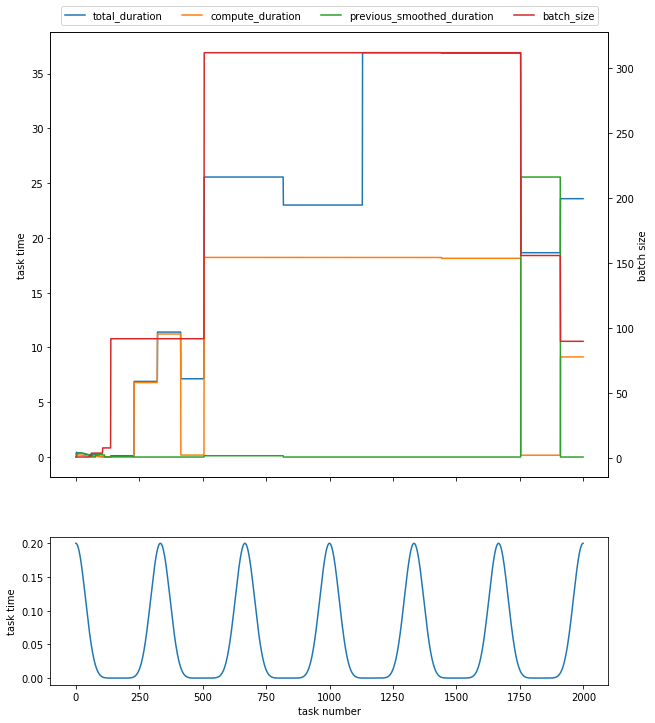

In [34]:
plot_batch_information(
    "AutoBatchingSuite",
    bench_name="track_cyclic_trend",
    n_jobs=2,
    commit_hash="record-batch-metrics"
)

In this case, joblib increases its batch size very quickly. Because the current joblib version does not protect well against worker strangling, high batch sizes combined with high-variance tasks can easily create stranglers. And indeed, it is specifically the partially cached and the cyclically trended benchmark on which joblib performs badly. 

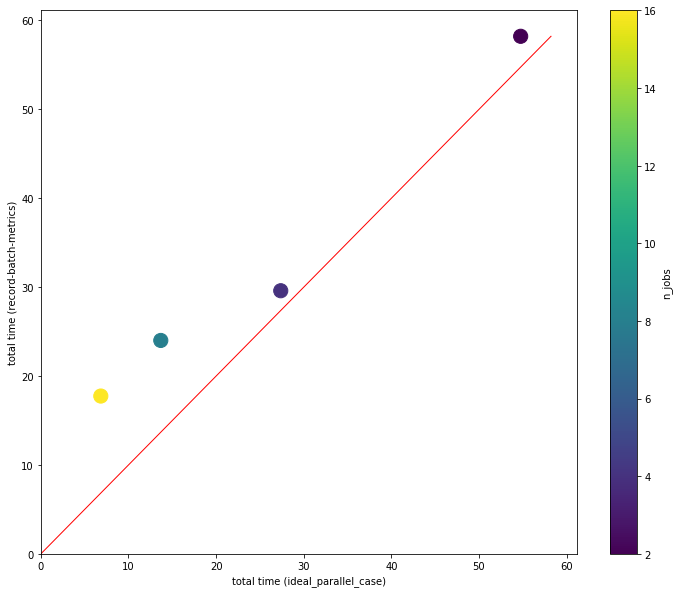

In [11]:
compare_total_running_time(
    "AutoBatchingSuite",
    bench_name="track_cyclic_trend", 
    benchmarked_branch='record-batch-metrics', 
    base_branch='ideal_parallel_case')

## Proposed changes

There are several ways we can try to address that problem, but for this, we need to understand where strangling comes from.
Strangling is when a worker is assigned a overwhelming amount of tasks within a batch, while other are left out with nothing to do. It typically happens for the last batches of a `Parallel` call. But given that joblib dispatches tasks by batch, if the batch size is very big, this can affect a lot the overall performance.



There are two ways a batch can be longers than other to process:
* A batch can contain more tasks than the others: If say we are given 100 tasks that performs quickly. Joblib will   notice that those tasks are fast and will start batching them. Maybe at task no. 20, joblib decides that a good batch size is 200. Thus it assign all the 80 remaining tasks to a single worker. The speedup is doomed to be no more than 1.2 in this case, which is disappointing.
* A batch can contain tasks that are longer to complete than tasks in other batches.

By the way, strangling is not a solvable problem all the time: if we want to parallelize 2 tasks of 0.01 seconds and 1 task of 1 second to 4 workers, using joblib will only make us gain 0.03 seconds compared to the serial case. Divinding the total running time by `n_jobs` is not always a feasable upper bound.  Batching decreases the total number of tasks-to-worker possible maps. Batching is thus a tradeoff between decreasing the serialization time, and increasing the strangling time.

Joblib actively protects itelf from the second case, by tracking the duration of batches over time, and updating the batch size accordingly, so that all batches take the same amount of time to process. The two assumptions of joblib are:


1. the batch size should be set such that the time taken to
   handle/compute all the tasks of a batch lies between an acceptable
   range (0.2 and 2 seconds)
2. batches $x-1$ and $x$ are assumed to have similar running
   times. For this reason, joblib "predicts" what the next ideal batch size
   should be depending on the previous batch duration

### Implementation details
In detail, joblib implements its batch size strategy as follows:

Each time `dispatch_one_batch` is called, compute the batch size. The
compute logic is:
```python
    def compute_batch_size(current_batch_size, smoothed_batch_duration):
        min_ratio = min_batch_duration / smoothed_batch_duration
        max_ratio = max_batch_duration / smoothed_batch_duration
        if min_ratio < 1:
            new_batch_size = current_batch_size * min_ratio
        if max_ratio > 1:
            new_batch_size /= 2
        else:
            new_batch_size = batch_size

        if new_batch_size != batch_size:
            reset_smoothed_batch_duration()
        return new_batch_size
```

Independently, each time a batch is completed, a callback updating the smoothed
batch duration is executed:

```python
    def update_batch_size(current_batch_size, this_batch_size,
                          this_batch_duration):
        if this_batch_size =! current_batch_size:
            # do not update the smoothed batch estimate using of "old" batches
            # that had a batch size different than the current objective.
            return
        else:
            # update the batch duration using exponentially weighted averages.
            smoothed_batch_duration = (
                0.8 * smoothed_batch_duration + 0.2 * this_batch_duration)
```

By looking at the code ruling batch size in joblib, we see that
* when joblib thinks the current batch size is too slow, it computes an
  optimal batch size and sets the new batch size to this optimal batch
  size.
* On the other hand, if the batch size is too high, joblib does not
  compute an ideal batch size, but simply divides the current batch size
  by 2.
  
In other words, the batch size can increase arbirtraly fast, but can only
decrease "slowly".

This behavior "favors" high batch sizes, and thus is more prone to strangling compared to serialization overhead. If we want to protect ourselves from strangling, we need to favor low batch sizes instead. This can be done very simply, by swapping the increase/decrease behavior: instead of quickly increasing and slowly decreasing, increase slowly and decrease quickly.
Here are the results:

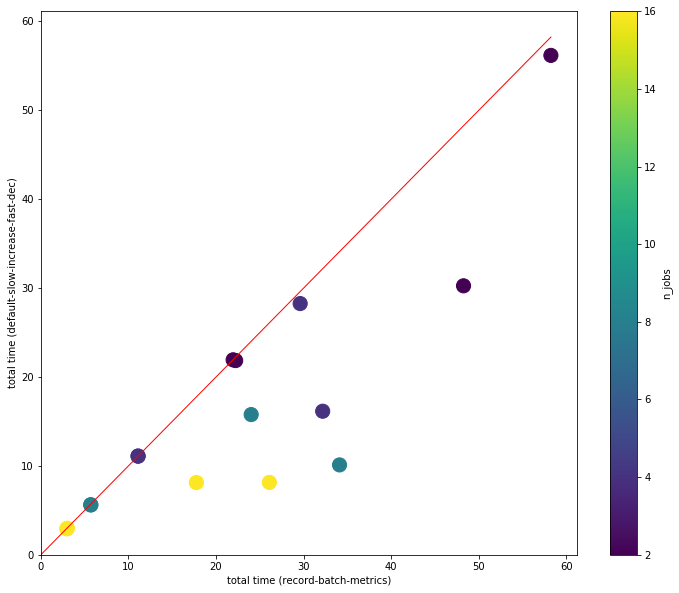

In [12]:
compare_total_running_time(
    "AutoBatchingSuite",
    bench_name=None, 
    benchmarked_branch="default-slow-increase-fast-decrease",
    # benchmarked_branch="no-starving-backend-agnostic-split-last-batch-end-to-end-duration"
    base_branch="record-batch-metrics")

We can already see a very nice improvement. The results are even close to the ideal parallel case!

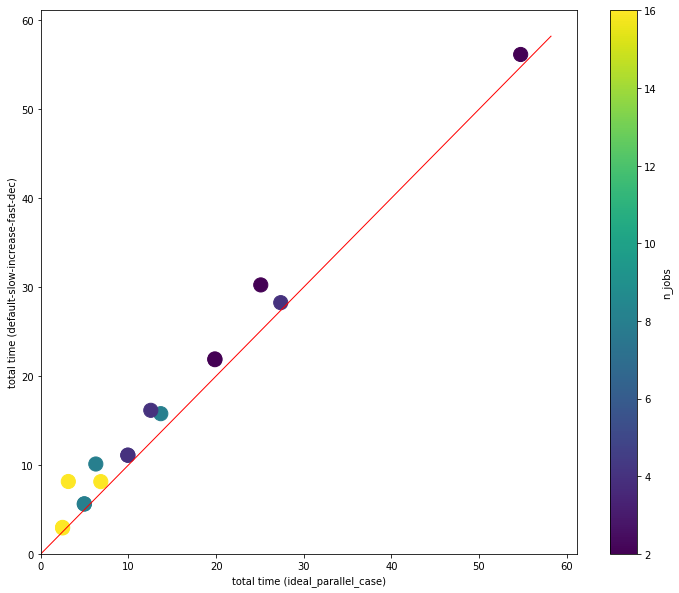

In [13]:
compare_total_running_time(
    "AutoBatchingSuite", 
    bench_name=None,
    benchmarked_branch="default-slow-increase-fast-decrease",
    base_branch="ideal_parallel_case")

By plotting the evolution of the batch size, we see that joblib manages more to track the evolution of the batches over time, and thus creates more balanced batches.

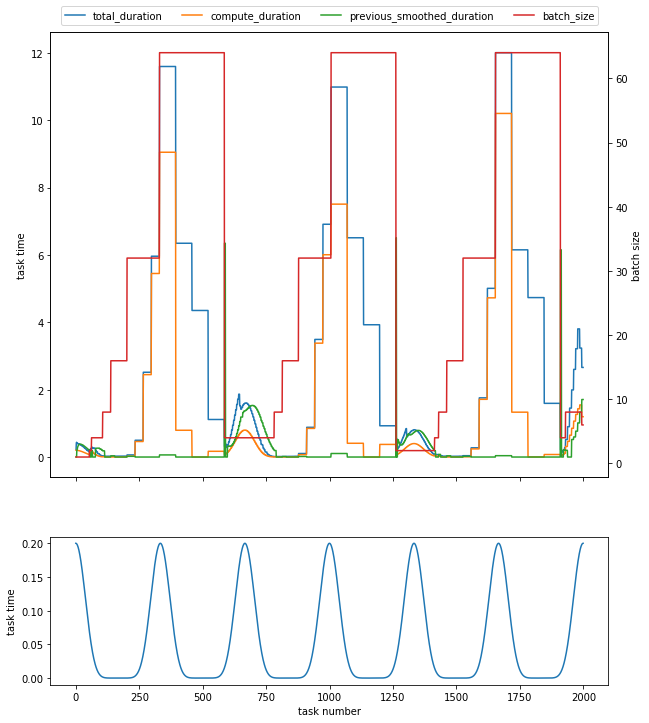

In [14]:
plot_batch_information(
    bench_class="AutoBatchingSuite",
    bench_name="track_cyclic_trend",
    n_jobs=2,
    commit_hash="default-slow-increase-fast-decrease")

### Addressing batch balancing

There is more we can do than being more conservative when increasing the batch size. Indeed, joblib has another flaw in its batching logic: when computing a batch size, it does not check how many batches of this specific size can be created before we reach the end of the task iterator. This is problematic because if the batch size increases, we can end up with one big batch being dispatched to a single worker, thus creating strangling.

This phenomenon appears clearly in the partially cached benchmarked, for which a special parameter is added: the number of cached tasks.

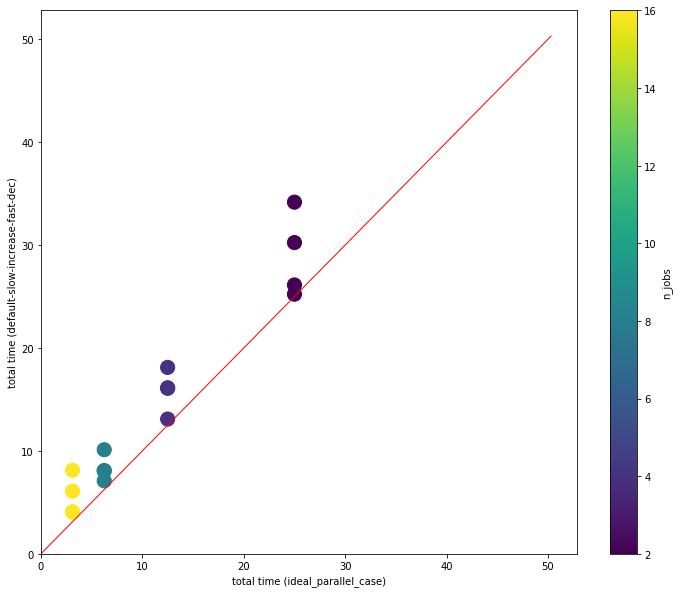

In [15]:
compare_total_running_time(
    "PartiallyCachedBenchmark", 
    bench_name="track_partially_cached",
    benchmarked_branch="default-slow-increase-fast-decrease",
    base_branch="ideal_parallel_case")

Something we can do to prevent final batches to be oversized, is to ensure that each time we create a batch with a new batch size, we can actually create `n_jobs` times this batch. This heuristic ensures optimal distribution in the case where all tasks are of the same time, and is a good rule of thumb when tasks have varying running times. We can see the resulting improvement in the plot below:

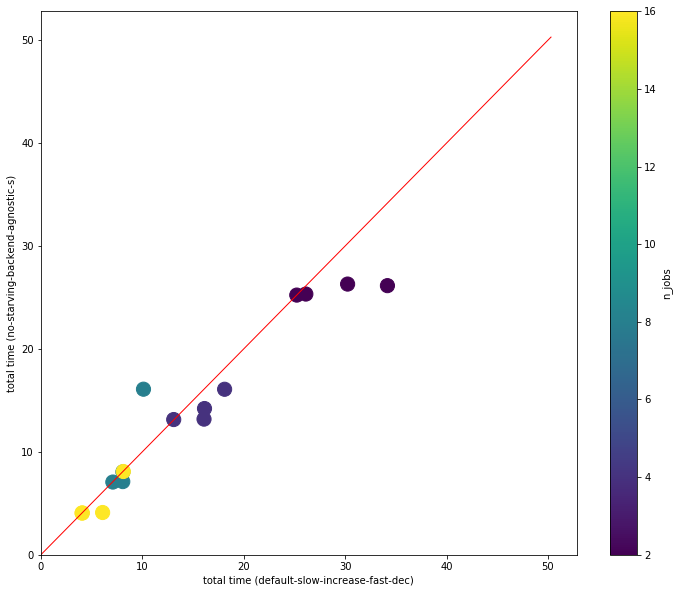

In [16]:
compare_total_running_time(
    "PartiallyCachedBenchmark",
    bench_name="track_partially_cached",
    benchmarked_branch="no-starving-backend-agnostic-split-last-batch-end-to-end-duration",
    base_branch="default-slow-increase-fast-decrease")

The only regression comes from the fact that apparently, the "default-slow-increase-fast-decrease", the batch size increases less quickly. This itself comes from the fact that `2*n_jobs` batches are pre-dispatched for this branch (wherease for the new branch it is only `n_jobs`), which causes, because of some complex race-conditions affecting the computation of the batch duration, the batch duration being updated less often. But it is not a controlled effect.

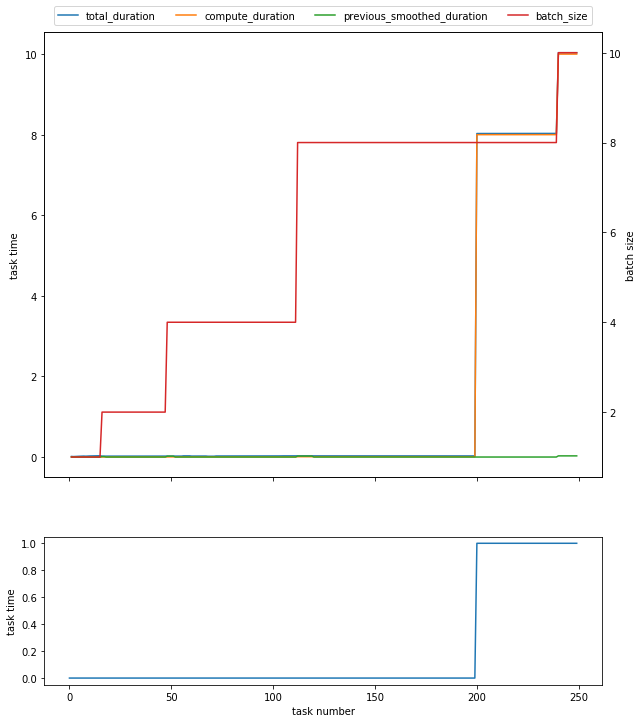

In [22]:
plot_batch_information(
    "PartiallyCachedBenchmark",
    n_jobs=8,
    n_cached=200,
    bench_name="track_partially_cached",
    commit_hash="default-slow-increase-fast-decrease",
)

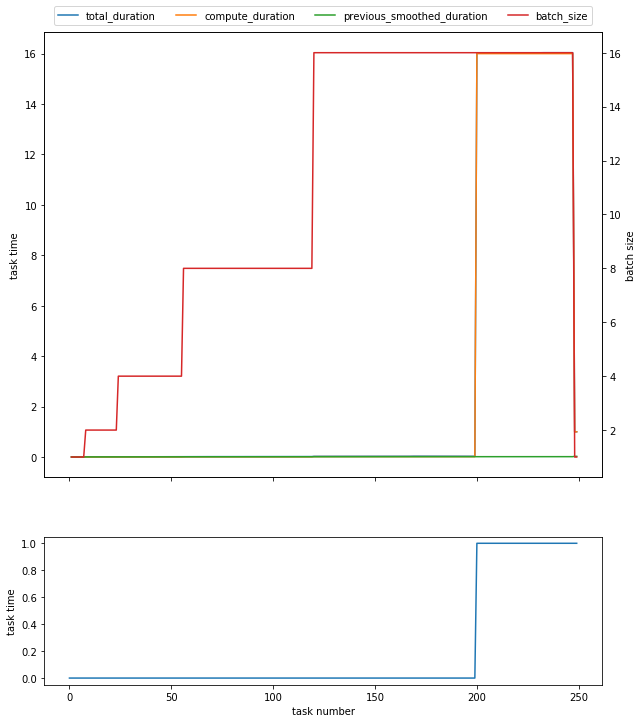

In [23]:
plot_batch_information(
    "PartiallyCachedBenchmark",
    n_jobs=8,
    n_cached=200,
    bench_name="track_partially_cached",
    commit_hash='no-starving-backend-agnostic-split-last-batch-end-to-end-duration'
)

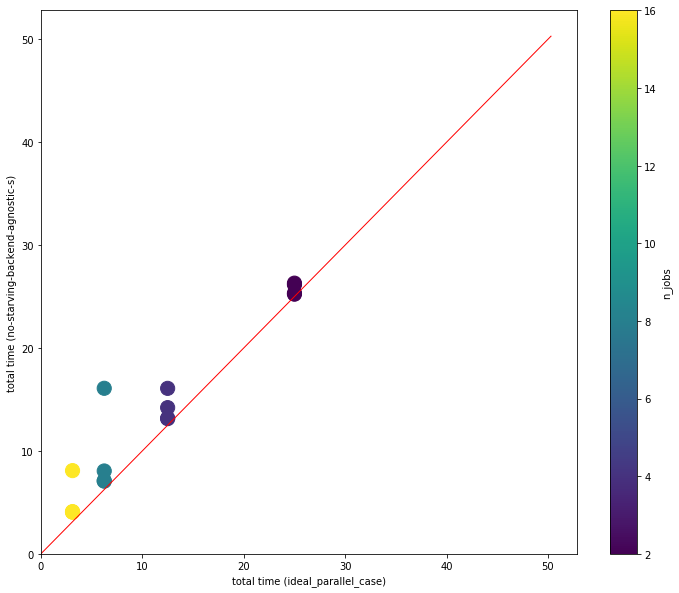

In [24]:
compare_total_running_time(
    "PartiallyCachedBenchmark",
    bench_name="track_partially_cached",
    benchmarked_branch="no-starving-backend-agnostic-split-last-batch-end-to-end-duration",
    base_branch="ideal_parallel_case")

All in all, even for pathological cases such as the partially cached benchmarks, we are getting close to the optimal speedup, which is a great thing.